<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/AprendizajeAutomatico/TP2/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencias de los Datos:
# Aprendizaje automático

## Trabajo práctico 2

- Professor: M.Sc.Saul Calderon.

- Students: 
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  

- July 28th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split as tts

## 1. Implementación de clasificadores lineales de dos clases. (40 puntos)

Sample data linearly separable


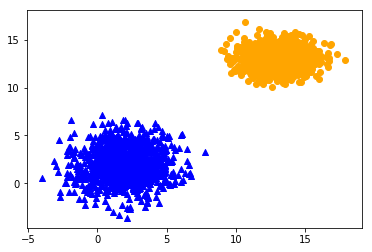

>epoch=0, cost=10168.216
>epoch=1, cost=8869.558
>epoch=2, cost=8855.741
>epoch=3, cost=8800.479
>epoch=4, cost=8717.587
>epoch=5, cost=8579.432
>epoch=6, cost=8386.015
>epoch=7, cost=5761.066
>epoch=8, cost=9864.275
>epoch=9, cost=8676.141
>epoch=10, cost=8607.062
>epoch=11, cost=8510.354
>epoch=12, cost=8427.461
>epoch=13, cost=7971.549
>epoch=14, cost=6548.551
>epoch=15, cost=1201.949
>epoch=16, cost=27.630
>epoch=17, cost=13.814
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


>epoch=52, cost=-0.001
>epoch=53, cost=-0.001
>epoch=54, cost=-0.001
>epoch=55, cost=-0.001
>epoch=56, cost=-0.001
>epoch=57, cost=-0.001
>epoch=58, cost=-0.001
>epoch=59, cost=-0.001
>epoch=60, cost=-0.001
>epoch=61, cost=-0.001
>epoch=62, cost=-0.001
>epoch=63, cost=-0.001
>epoch=64, cost=-0.001
>epoch=65, cost=-0.001
>epoch=66, cost=-0.001
>epoch=67, cost=-0.001
>epoch=68, cost=-0.001
>epoch=69, cost=-0.001
>epoch=70, cost=-0.001
>epoch=71, cost=-0.001
>epoch=72, cost=-0.001
>epoch=73, cost=-0.001
>epoch=74, cost=-0.001
>epoch=75, cost=-0.001
>epoch=76, cost=-0.001
>epoch=77, cost=-0.001
>epoch=78, cost=-0.001
>epoch=79, cost=-0.001
>epoch=80, cost=-0.001
>epoch=81, cost=-0.001
>epoch=82, cost=-0.001
>epoch=83, cost=-0.001
>epoch=84, cost=-0.001
>epoch=85, cost=-0.001
>epoch=86, cost=-0.001
>epoch=87, cost=-0.001
>epoch=88, cost=-0.001
>epoch=89, cost=-0.001
>epoch=90, cost=-0.001
>epoch=91, cost=-0.001
>epoch=92, cost=-0.001
>epoch=93, cost=-0.001
>epoch=94, cost=-0.001
>epoch=95, 

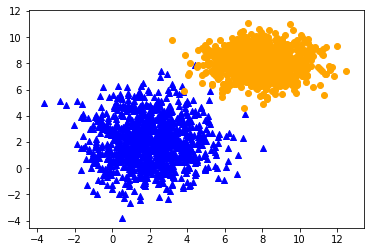

>epoch=0, cost=9947.166
>epoch=1, cost=9104.422
>epoch=2, cost=9062.976
>epoch=3, cost=8952.450
>epoch=4, cost=8537.985
>epoch=5, cost=9739.935
>epoch=6, cost=8952.450
>epoch=7, cost=8897.188
>epoch=8, cost=8551.801
>epoch=9, cost=7018.279
>epoch=10, cost=9739.935
>epoch=11, cost=8855.742
>epoch=12, cost=8648.510
>epoch=13, cost=8164.967
>epoch=14, cost=5788.699
>epoch=15, cost=9560.332
>epoch=16, cost=8648.510
>epoch=17, cost=8358.383
>epoch=18, cost=7598.530
>epoch=19, cost=4959.768
>epoch=20, cost=1243.395
>epoch=21, cost=2072.326
>epoch=22, cost=331.571
>epoch=23, cost=82.892
>epoch=24, cost=82.892
>epoch=25, cost=69.076
>epoch=26, cost=82.892
>epoch=27, cost=82.892
>epoch=28, cost=82.892
>epoch=29, cost=82.892
>epoch=30, cost=82.892
>epoch=31, cost=82.892
>epoch=32, cost=82.892
>epoch=33, cost=82.892
>epoch=34, cost=69.076
>epoch=35, cost=82.892
>epoch=36, cost=82.892
>epoch=37, cost=82.892
>epoch=38, cost=82.892
>epoch=39, cost=69.076
>epoch=40, cost=69.076
>epoch=41, cost=69.076

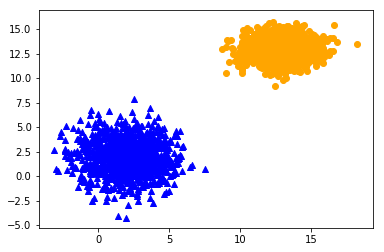

>epoch=0, cost=10043.876
>epoch=1, cost=9049.159
>epoch=2, cost=9021.528
>epoch=3, cost=8980.081
>epoch=4, cost=8897.188
>epoch=5, cost=8786.664
>epoch=6, cost=8289.306
>epoch=7, cost=5843.960
>epoch=8, cost=9836.644
>epoch=9, cost=8869.557
>epoch=10, cost=8841.926
>epoch=11, cost=8607.062
>epoch=12, cost=8372.199
>epoch=13, cost=7930.103
>epoch=14, cost=6645.260
>epoch=15, cost=953.269
>epoch=16, cost=41.445
>epoch=17, cost=27.630
>epoch=18, cost=27.630
>epoch=19, cost=13.814
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, c

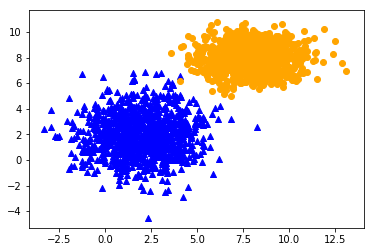

>epoch=0, cost=9822.829
>epoch=1, cost=9284.022
>epoch=2, cost=9187.313
>epoch=3, cost=9104.420
>epoch=4, cost=8620.877
>epoch=5, cost=9698.488
>epoch=6, cost=9118.235
>epoch=7, cost=8952.449
>epoch=8, cost=8648.508
>epoch=9, cost=7045.909
>epoch=10, cost=9698.488
>epoch=11, cost=8883.372
>epoch=12, cost=8676.140
>epoch=13, cost=8164.966
>epoch=14, cost=5857.775
>epoch=15, cost=9574.149
>epoch=16, cost=8703.771
>epoch=17, cost=8468.906
>epoch=18, cost=7722.869
>epoch=19, cost=4918.321
>epoch=20, cost=69.076
>epoch=21, cost=41.445
>epoch=22, cost=41.445
>epoch=23, cost=41.445
>epoch=24, cost=41.445
>epoch=25, cost=27.630
>epoch=26, cost=41.445
>epoch=27, cost=27.630
>epoch=28, cost=27.630
>epoch=29, cost=41.445
>epoch=30, cost=27.630
>epoch=31, cost=41.445
>epoch=32, cost=27.630
>epoch=33, cost=41.445
>epoch=34, cost=41.445
>epoch=35, cost=41.445
>epoch=36, cost=41.445
>epoch=37, cost=41.445
>epoch=38, cost=41.445
>epoch=39, cost=41.445
>epoch=40, cost=41.445
>epoch=41, cost=41.445
>epo

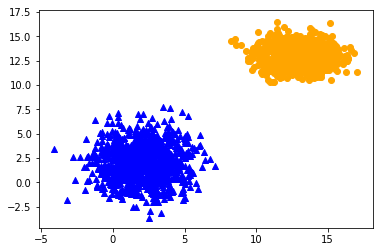

>epoch=0, cost=9864.274
>epoch=1, cost=9242.576
>epoch=2, cost=9228.760
>epoch=3, cost=9187.314
>epoch=4, cost=9035.342
>epoch=5, cost=8869.557
>epoch=6, cost=8275.489
>epoch=7, cost=4186.099
>epoch=8, cost=9726.119
>epoch=9, cost=8980.080
>epoch=10, cost=8911.003
>epoch=11, cost=8828.110
>epoch=12, cost=8565.615
>epoch=13, cost=7861.024
>epoch=14, cost=6161.716
>epoch=15, cost=483.542
>epoch=16, cost=96.707
>epoch=17, cost=27.630
>epoch=18, cost=27.630
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

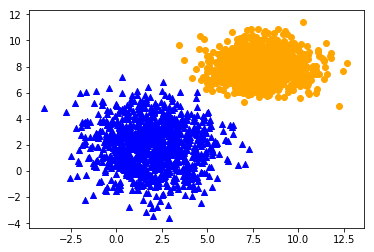

>epoch=0, cost=9933.352
>epoch=1, cost=9159.684
>epoch=2, cost=9104.422
>epoch=3, cost=8980.081
>epoch=4, cost=8510.354
>epoch=5, cost=221.047
>epoch=6, cost=276.309
>epoch=7, cost=967.085
>epoch=8, cost=9753.750
>epoch=9, cost=8980.081
>epoch=10, cost=8800.479
>epoch=11, cost=8482.723
>epoch=12, cost=7197.880
>epoch=13, cost=124.338
>epoch=14, cost=13.814
>epoch=15, cost=13.814
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.0

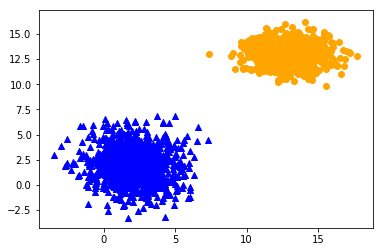

>epoch=0, cost=9753.750
>epoch=1, cost=9311.653
>epoch=2, cost=9297.838
>epoch=3, cost=9284.022
>epoch=4, cost=9214.945
>epoch=5, cost=9076.790
>epoch=6, cost=8510.354
>epoch=7, cost=3232.829
>epoch=8, cost=9698.488
>epoch=9, cost=9214.945
>epoch=10, cost=9132.052
>epoch=11, cost=9021.528
>epoch=12, cost=8883.373
>epoch=13, cost=8220.229
>epoch=14, cost=6355.134
>epoch=15, cost=359.202
>epoch=16, cost=96.707
>epoch=17, cost=69.076
>epoch=18, cost=27.630
>epoch=19, cost=13.814
>epoch=20, cost=13.814
>epoch=21, cost=13.814
>epoch=22, cost=13.814
>epoch=23, cost=13.814
>epoch=24, cost=13.814
>epoch=25, cost=13.814
>epoch=26, cost=13.814
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

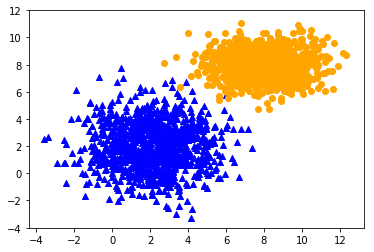

>epoch=0, cost=10043.877
>epoch=1, cost=9021.527
>epoch=2, cost=9007.712
>epoch=3, cost=8980.080
>epoch=4, cost=8551.801
>epoch=5, cost=9712.304
>epoch=6, cost=8966.266
>epoch=7, cost=8841.926
>epoch=8, cost=8551.801
>epoch=9, cost=7391.296
>epoch=10, cost=9836.644
>epoch=11, cost=8828.110
>epoch=12, cost=8579.432
>epoch=13, cost=8109.703
>epoch=14, cost=6493.289
>epoch=15, cost=442.095
>epoch=16, cost=345.387
>epoch=17, cost=110.523
>epoch=18, cost=69.076
>epoch=19, cost=69.076
>epoch=20, cost=69.076
>epoch=21, cost=69.076
>epoch=22, cost=82.892
>epoch=23, cost=55.261
>epoch=24, cost=82.892
>epoch=25, cost=55.261
>epoch=26, cost=69.076
>epoch=27, cost=55.261
>epoch=28, cost=82.892
>epoch=29, cost=55.261
>epoch=30, cost=82.892
>epoch=31, cost=55.261
>epoch=32, cost=69.076
>epoch=33, cost=55.261
>epoch=34, cost=55.261
>epoch=35, cost=55.261
>epoch=36, cost=55.261
>epoch=37, cost=55.261
>epoch=38, cost=55.261
>epoch=39, cost=55.261
>epoch=40, cost=55.261
>epoch=41, cost=55.261
>epoch=42,

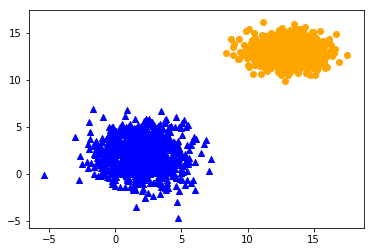

>epoch=0, cost=9809.013
>epoch=1, cost=9228.761
>epoch=2, cost=9201.130
>epoch=3, cost=9159.682
>epoch=4, cost=9090.604
>epoch=5, cost=8897.188
>epoch=6, cost=8330.752
>epoch=7, cost=2887.441
>epoch=8, cost=9657.041
>epoch=9, cost=9076.789
>epoch=10, cost=9035.343
>epoch=11, cost=8786.663
>epoch=12, cost=8551.801
>epoch=13, cost=8095.888
>epoch=14, cost=6396.580
>epoch=15, cost=193.416
>epoch=16, cost=82.892
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

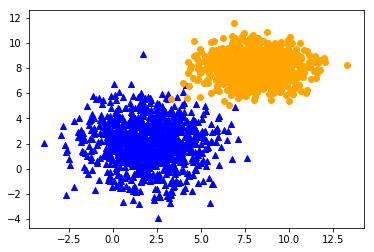

>epoch=0, cost=9726.119
>epoch=1, cost=9325.470
>epoch=2, cost=9297.839
>epoch=3, cost=9228.761
>epoch=4, cost=8731.402
>epoch=5, cost=9546.518
>epoch=6, cost=9242.576
>epoch=7, cost=9132.053
>epoch=8, cost=8772.849
>epoch=9, cost=6161.716
>epoch=10, cost=9546.518
>epoch=11, cost=9090.605
>epoch=12, cost=8828.110
>epoch=13, cost=8082.073
>epoch=14, cost=4282.808
>epoch=15, cost=9546.518
>epoch=16, cost=8911.004
>epoch=17, cost=8620.878
>epoch=18, cost=7681.423
>epoch=19, cost=4393.332
>epoch=20, cost=497.357
>epoch=21, cost=124.338
>epoch=22, cost=96.707
>epoch=23, cost=69.076
>epoch=24, cost=69.076
>epoch=25, cost=69.076
>epoch=26, cost=69.076
>epoch=27, cost=69.076
>epoch=28, cost=82.892
>epoch=29, cost=69.076
>epoch=30, cost=82.892
>epoch=31, cost=69.076
>epoch=32, cost=82.892
>epoch=33, cost=82.892
>epoch=34, cost=82.892
>epoch=35, cost=69.076
>epoch=36, cost=82.892
>epoch=37, cost=69.076
>epoch=38, cost=82.892
>epoch=39, cost=69.076
>epoch=40, cost=69.076
>epoch=41, cost=69.076
>e

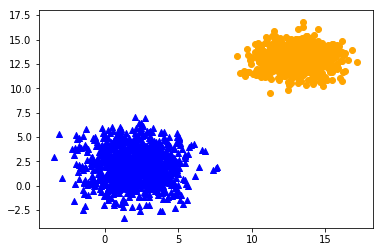

>epoch=0, cost=9712.304
>epoch=1, cost=9270.207
>epoch=2, cost=9256.391
>epoch=3, cost=9201.129
>epoch=4, cost=9062.974
>epoch=5, cost=8911.003
>epoch=6, cost=8372.198
>epoch=7, cost=1353.919
>epoch=8, cost=6438.027
>epoch=9, cost=8966.265
>epoch=10, cost=8800.479
>epoch=11, cost=8386.014
>epoch=12, cost=7128.802
>epoch=13, cost=41.445
>epoch=14, cost=27.630
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0

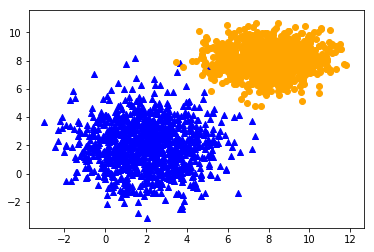

>epoch=0, cost=9739.936
>epoch=1, cost=9339.284
>epoch=2, cost=9284.022
>epoch=3, cost=9090.605
>epoch=4, cost=8648.510
>epoch=5, cost=9601.779
>epoch=6, cost=9104.421
>epoch=7, cost=8952.451
>epoch=8, cost=8689.956
>epoch=9, cost=6852.492
>epoch=10, cost=9601.779
>epoch=11, cost=8924.820
>epoch=12, cost=8731.402
>epoch=13, cost=8054.442
>epoch=14, cost=5222.263
>epoch=15, cost=9601.779
>epoch=16, cost=8800.479
>epoch=17, cost=8482.723
>epoch=18, cost=7681.423
>epoch=19, cost=4945.952
>epoch=20, cost=124.338
>epoch=21, cost=55.261
>epoch=22, cost=55.261
>epoch=23, cost=55.261
>epoch=24, cost=55.261
>epoch=25, cost=55.261
>epoch=26, cost=41.445
>epoch=27, cost=55.261
>epoch=28, cost=55.261
>epoch=29, cost=41.445
>epoch=30, cost=41.445
>epoch=31, cost=41.445
>epoch=32, cost=41.445
>epoch=33, cost=41.445
>epoch=34, cost=27.630
>epoch=35, cost=27.630
>epoch=36, cost=27.630
>epoch=37, cost=41.445
>epoch=38, cost=27.630
>epoch=39, cost=27.630
>epoch=40, cost=27.630
>epoch=41, cost=27.630
>ep

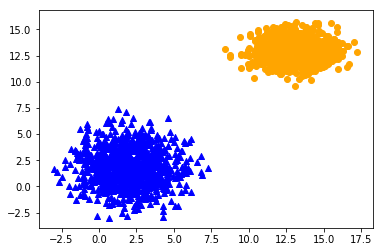

>epoch=0, cost=9739.935
>epoch=1, cost=9284.022
>epoch=2, cost=9270.207
>epoch=3, cost=9187.313
>epoch=4, cost=9118.236
>epoch=5, cost=8938.635
>epoch=6, cost=8303.121
>epoch=7, cost=3467.693
>epoch=8, cost=9574.148
>epoch=9, cost=9104.421
>epoch=10, cost=9035.343
>epoch=11, cost=8869.557
>epoch=12, cost=8579.431
>epoch=13, cost=7943.917
>epoch=14, cost=6134.085
>epoch=15, cost=524.988
>epoch=16, cost=69.076
>epoch=17, cost=41.445
>epoch=18, cost=13.814
>epoch=19, cost=13.814
>epoch=20, cost=13.814
>epoch=21, cost=13.814
>epoch=22, cost=13.814
>epoch=23, cost=13.814
>epoch=24, cost=13.814
>epoch=25, cost=13.814
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

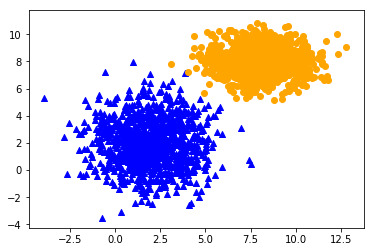

>epoch=0, cost=9933.352
>epoch=1, cost=9214.945
>epoch=2, cost=9187.314
>epoch=3, cost=9104.420
>epoch=4, cost=8717.586
>epoch=5, cost=9767.565
>epoch=6, cost=9104.420
>epoch=7, cost=9035.343
>epoch=8, cost=8759.032
>epoch=9, cost=7432.743
>epoch=10, cost=9767.565
>epoch=11, cost=8993.896
>epoch=12, cost=8786.665
>epoch=13, cost=8234.043
>epoch=14, cost=6327.503
>epoch=15, cost=566.435
>epoch=16, cost=469.726
>epoch=17, cost=41.445
>epoch=18, cost=41.445
>epoch=19, cost=27.630
>epoch=20, cost=27.630
>epoch=21, cost=27.630
>epoch=22, cost=27.630
>epoch=23, cost=27.630
>epoch=24, cost=27.630
>epoch=25, cost=27.630
>epoch=26, cost=27.630
>epoch=27, cost=27.630
>epoch=28, cost=27.630
>epoch=29, cost=27.630
>epoch=30, cost=27.630
>epoch=31, cost=27.630
>epoch=32, cost=27.630
>epoch=33, cost=27.630
>epoch=34, cost=27.630
>epoch=35, cost=27.630
>epoch=36, cost=27.630
>epoch=37, cost=27.630
>epoch=38, cost=27.630
>epoch=39, cost=27.630
>epoch=40, cost=27.630
>epoch=41, cost=27.630
>epoch=42, c

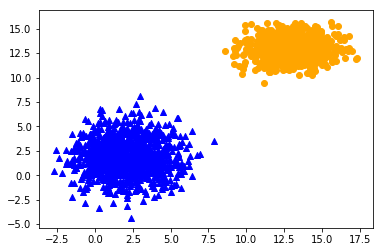

>epoch=0, cost=9960.981
>epoch=1, cost=9132.053
>epoch=2, cost=9076.790
>epoch=3, cost=9049.159
>epoch=4, cost=8924.820
>epoch=5, cost=8745.218
>epoch=6, cost=8109.704
>epoch=7, cost=4890.690
>epoch=8, cost=9809.012
>epoch=9, cost=8897.188
>epoch=10, cost=8828.110
>epoch=11, cost=8620.878
>epoch=12, cost=8344.567
>epoch=13, cost=7902.471
>epoch=14, cost=6203.163
>epoch=15, cost=552.619
>epoch=16, cost=27.630
>epoch=17, cost=27.630
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

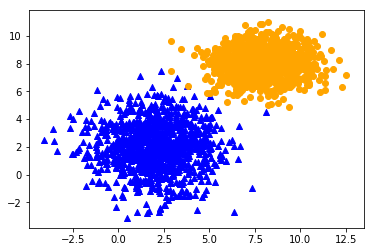

>epoch=0, cost=9919.536
>epoch=1, cost=9173.498
>epoch=2, cost=9159.683
>epoch=3, cost=9090.604
>epoch=4, cost=8662.324
>epoch=5, cost=9726.119
>epoch=6, cost=9090.604
>epoch=7, cost=8966.266
>epoch=8, cost=8689.955
>epoch=9, cost=7018.278
>epoch=10, cost=9726.119
>epoch=11, cost=8938.635
>epoch=12, cost=8759.033
>epoch=13, cost=8206.412
>epoch=14, cost=5208.447
>epoch=15, cost=9726.119
>epoch=16, cost=8841.926
>epoch=17, cost=8455.091
>epoch=18, cost=7861.024
>epoch=19, cost=4642.011
>epoch=20, cost=538.804
>epoch=21, cost=179.600
>epoch=22, cost=82.892
>epoch=23, cost=55.261
>epoch=24, cost=41.445
>epoch=25, cost=41.445
>epoch=26, cost=41.445
>epoch=27, cost=41.445
>epoch=28, cost=41.445
>epoch=29, cost=27.630
>epoch=30, cost=27.630
>epoch=31, cost=27.630
>epoch=32, cost=41.445
>epoch=33, cost=27.630
>epoch=34, cost=27.630
>epoch=35, cost=27.630
>epoch=36, cost=27.630
>epoch=37, cost=27.630
>epoch=38, cost=41.445
>epoch=39, cost=27.630
>epoch=40, cost=27.630
>epoch=41, cost=27.630
>e

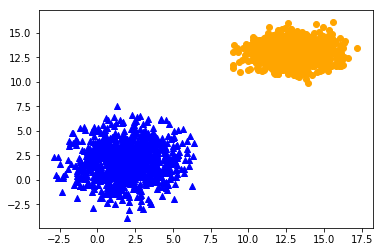

>epoch=0, cost=9767.565
>epoch=1, cost=9201.130
>epoch=2, cost=9132.053
>epoch=3, cost=9035.344
>epoch=4, cost=8938.635
>epoch=5, cost=8731.401
>epoch=6, cost=8247.858
>epoch=7, cost=3288.092
>epoch=8, cost=9518.886
>epoch=9, cost=8897.188
>epoch=10, cost=8869.557
>epoch=11, cost=8689.955
>epoch=12, cost=8524.169
>epoch=13, cost=7999.180
>epoch=14, cost=6106.455
>epoch=15, cost=455.911
>epoch=16, cost=124.338
>epoch=17, cost=82.892
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, c

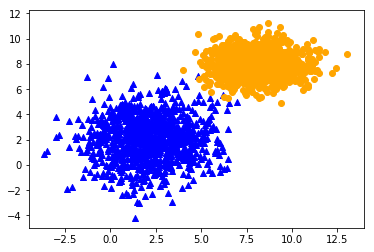

>epoch=0, cost=9601.779
>epoch=1, cost=9518.886
>epoch=2, cost=9449.808
>epoch=3, cost=9339.284
>epoch=4, cost=8413.645
>epoch=5, cost=9435.994
>epoch=6, cost=9353.100
>epoch=7, cost=9132.052
>epoch=8, cost=8537.984
>epoch=9, cost=55.261
>epoch=10, cost=41.445
>epoch=11, cost=69.076
>epoch=12, cost=41.445
>epoch=13, cost=69.076
>epoch=14, cost=41.445
>epoch=15, cost=69.076
>epoch=16, cost=41.445
>epoch=17, cost=55.261
>epoch=18, cost=27.630
>epoch=19, cost=27.630
>epoch=20, cost=27.630
>epoch=21, cost=27.630
>epoch=22, cost=27.630
>epoch=23, cost=13.814
>epoch=24, cost=41.445
>epoch=25, cost=13.814
>epoch=26, cost=41.445
>epoch=27, cost=27.630
>epoch=28, cost=41.445
>epoch=29, cost=41.445
>epoch=30, cost=27.630
>epoch=31, cost=41.445
>epoch=32, cost=27.630
>epoch=33, cost=27.630
>epoch=34, cost=27.630
>epoch=35, cost=13.814
>epoch=36, cost=41.445
>epoch=37, cost=13.814
>epoch=38, cost=41.445
>epoch=39, cost=13.814
>epoch=40, cost=41.445
>epoch=41, cost=13.814
>epoch=42, cost=41.445
>ep

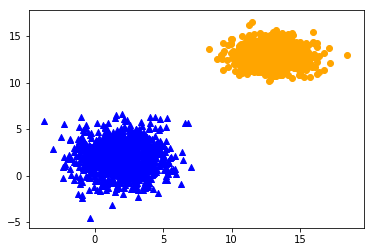

>epoch=0, cost=9753.750
>epoch=1, cost=9366.916
>epoch=2, cost=9311.654
>epoch=3, cost=9242.576
>epoch=4, cost=9201.130
>epoch=5, cost=8966.266
>epoch=6, cost=8427.461
>epoch=7, cost=27.630
>epoch=8, cost=27.630
>epoch=9, cost=13.814
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch=

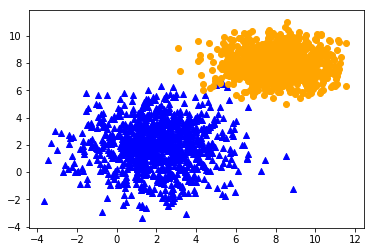

>epoch=0, cost=9919.537
>epoch=1, cost=9173.498
>epoch=2, cost=9145.867
>epoch=3, cost=9007.712
>epoch=4, cost=8579.431
>epoch=5, cost=9629.410
>epoch=6, cost=9007.712
>epoch=7, cost=8841.926
>epoch=8, cost=8579.431
>epoch=9, cost=7059.725
>epoch=10, cost=9629.410
>epoch=11, cost=8786.663
>epoch=12, cost=8662.324
>epoch=13, cost=8095.888
>epoch=14, cost=5470.941
>epoch=15, cost=9518.887
>epoch=16, cost=8689.955
>epoch=17, cost=8386.014
>epoch=18, cost=7681.422
>epoch=19, cost=4863.059
>epoch=20, cost=96.707
>epoch=21, cost=82.892
>epoch=22, cost=41.445
>epoch=23, cost=55.261
>epoch=24, cost=55.261
>epoch=25, cost=55.261
>epoch=26, cost=69.076
>epoch=27, cost=55.261
>epoch=28, cost=55.261
>epoch=29, cost=55.261
>epoch=30, cost=55.261
>epoch=31, cost=55.261
>epoch=32, cost=55.261
>epoch=33, cost=55.261
>epoch=34, cost=69.076
>epoch=35, cost=55.261
>epoch=36, cost=55.261
>epoch=37, cost=55.261
>epoch=38, cost=55.261
>epoch=39, cost=55.261
>epoch=40, cost=55.261
>epoch=41, cost=55.261
>epo

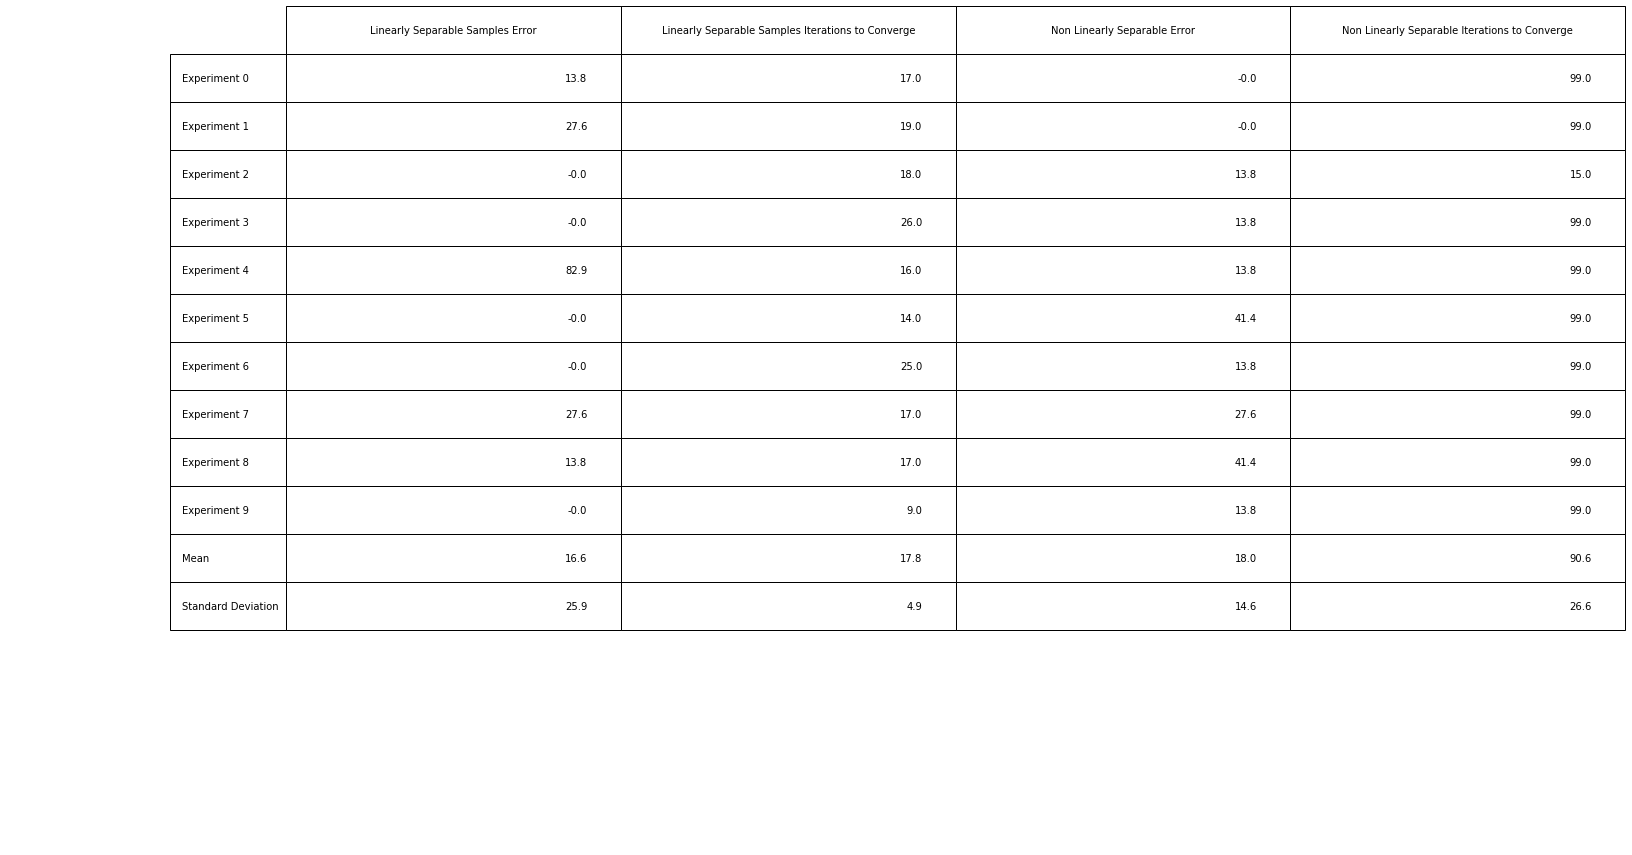

In [2]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [6, 6], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2
    """
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]

    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
        
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)

    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1], marker='^', c='blue')
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker='o', c='orange')

    plt.show()
    
    # Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = 0 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)


def createDataOneClass(means, covarianceMatrix, numberSamples):
    """
    Creates data with gaussian distribution
    """
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    return samples

def sigmoid(x):
    """
    Sigmoid activation function
    """
    return 1/(1+np.exp(-x))

def forward(samples, w, threshold=0.5, lowerLimit = 0, upperLimit = 1):
    """
    Get model output.
    param samples: samples used to estimated targets. 
    param w: network's weights. 
    param threshold: neuron's threshold of the transfer function.
    param lowerLimit: lower limit of the transfer function.
    param upperLimit: upper limit of the transfer function.
    return: Estimates the model outputs using the sigmoid activation function with values of lowerLimit and upperLimit.   
    """

    # Define vectorize sigmoid to apply to m*w
    vectorize_sigmoid = np.vectorize(sigmoid)
    EstimatedTargets = samples.mm(w)
    
    # Apply sigmoid function to m*w
    EstimatedTargets = torch.from_numpy(vectorize_sigmoid(EstimatedTargets.numpy())).type(torch.FloatTensor)
    
    # Classify predictions
    EstimatedTargets[EstimatedTargets>threshold] = upperLimit
    EstimatedTargets[EstimatedTargets<=threshold] = lowerLimit
    
    return EstimatedTargets

def vectorTransposed(w):
    """
    Calculate the transposed of a vector.
    return: the transposed vector.   
    """
    w2Drow = w.reshape(-1, w.shape[0])
    return w2Drow.transpose(0, 1)  

def calculateError(targets, estimated_targets):
    """
    Calculate the cost using the versimilitude error. 
    """
    cost = ((targets*torch.log((estimated_targets+0.1e-5))) + (1-targets)*torch.log((1-estimated_targets + 0.1e-5)))
    return -torch.sum(cost)

def train_model(samples, targets, epochs=10):
   """
   Train the logistic regression model adjusting the neural network's weights.
   param samples: Conjunction of entries
   param targets: Types of clases (Class 1 and Class 2)
   param epochs: number of training cycles.
   return: updated weights   
   """

   def updateDeltaWeight(samples, targets_transpose, estimated_targets_transpose, wT, alpha=0.1):
      """
      Estimate delta weight using stochastic gradient descent
      param SamplesAllBias: NumSamples x NumDimensions 
      param TargetsAllT: NumSamples' clases 
      param EstimatedTargetsAllT: estimated clases
      param wT: previous weights
      param eta: learning rate
      
      return: updated weights.   
      """
      samples_transpose = samples.transpose(0, 1)    
      return wT + alpha * samples_transpose.mm(targets_transpose - estimated_targets_transpose)
   

   # Generate random weights
   samples_dimensions = samples.size()
   w = torch.ones(samples_dimensions[1],1)
   wT = vectorTransposed(w)

   # Calculate Targets transpose 
   targets_transpose = vectorTransposed(targets)
   
    
   # Train during n epochs
   epochToConv = epochs
   for epoch in range(epochs):
       # Calculate predictions (estimated targets)
       estimated_targets_transpose = vectorTransposed(forward(samples, wT))
       
       # Calculate error
       error  = calculateError(targets_transpose, estimated_targets_transpose)
       print('>epoch=%d, cost=%.3f' % (epoch, error))
        
       if error > 0.1e-5 :  
          # Update weights 
          wT = updateDeltaWeight(samples, targets_transpose, estimated_targets_transpose, wT)
          epochToConv=epoch  

       #epoch = epoch + 1

   return wT, epochToConv


def plotErrorTable(error, collabel, rows) : 
    #plot errors
    fig, ax = plt.subplots()

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis("off")    
    
    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(collabel))
    
    #Row's labels    
    #rows = ['Muestras %d' % x for x in rowlabels]
      
    # Create text labels for the table
    cell_text = []

    data =error.numpy()
    n_rows = len(data)
       
    for row in range(n_rows):
        y_offset = np.zeros(len(collabel))
        y_offset =  y_offset + data[row]
        cell_text.append(['%1.1f' % x for x in y_offset])
        
    the_table = ax.table(cellText=cell_text,rowLabels=rows, colLabels=collabel,loc='top')     

    #the_table.auto_set_font_size(False)
    the_table.set_fontsize(24)
    the_table.scale(4, 4)
    
    return


# Test the logistic regression model  
def logistic_regression(samples, targets, epochs = 50, test_size = 0.3):    

    # Define the set of training samples as 70% (randomly selected) and test samples as 30%.
    X_train, X_test, Y_train, Y_test = tts(samples.numpy(), targets.numpy(), test_size = test_size)

    # Train the logistic regression model
    wF, epochToConv = train_model(torch.tensor(X_train), torch.tensor(Y_train), epochs=epochs)

    # Test the trained logistic regression model
    Estimated_Y = forward(torch.tensor(X_test), wF)

    # Calculate error
    testError = calculateError(torch.tensor(Y_test), Estimated_Y )
    print("Error total para el conjunto de muestras:", testError)
    return testError, epochToConv
  

def test_logistic_regression():
    totalEpochs = 100
    samplesPerClass = 1000
    experiments = 10
    
    #vector with all experiments' errors 
    vExperimentError= torch.zeros(experiments,4)    
    
    #Table definition
    collabel=('Linearly Separable Samples Error', 'Linearly Separable Samples Iterations to Converge', 'Non Linearly Separable Error', 'Non Linearly Separable Iterations to Converge')
    rowslabel = ['Experiment %d' % x for x in range(0, experiments)] 
    rowslabel.append('Mean') 
    rowslabel.append('Standard Deviation')
 
    # Compute experiments using linearly separables and non separables samples
    for i in range(0, experiments):

      # Sample data type 1. Linearly separable
      print("Sample data linearly separable")
      (targets, samples) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [13, 13])
      finalError, epochToConv = logistic_regression(samples, targets, epochs = totalEpochs, test_size = 0.3)
      vExperimentError[i][0] = finalError
      vExperimentError[i][1] = epochToConv

      # Sample data type 2. No linearly separable
      print("Sample data linearly separable")
      (targets, samples) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [8, 8])
      finalError, epochToConv = logistic_regression(samples, targets, epochs = totalEpochs, test_size = 0.3)
      vExperimentError[i][2] = finalError
      vExperimentError[i][3] = epochToConv

    print("======================================")
    print("PARAMETERS")
    print("--- Epochs: ", totalEpochs)
    print("--- Samples per class: ", samplesPerClass)
    print("--- Experiments: ", experiments)    
    print("======================================")

    #Compute the mean and the standard deviation    
    experimentsMean = vExperimentError.mean(dim=0)
    experimentsStd = vExperimentError.std(dim=0)    
    
    # Update the table to be displayed
    tableData = torch.cat((vExperimentError, torch.zeros(2,4)), 0)
    tableData[experiments,:] = experimentsMean
    tableData[experiments+1,:] = experimentsStd
    

    #Plot the result table
    plotErrorTable(tableData, collabel, rowslabel)

    
test_logistic_regression()

#¿Cuál de las funciones matemáticas vistas en clase puede utilizarse a la salida del regresor logístico para realizar una clasificación binaria?
Se puede utilizar la función sigmoidal ya es una función suave y continua acotada entre 0 y 1.




## 2. Experimentos, análisis y el enfoque de mínimos cuadrados regularizado. (60 puntos)

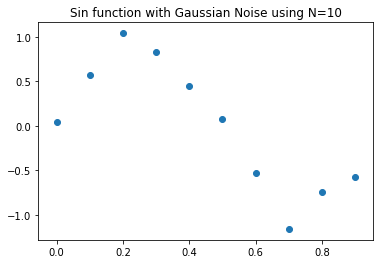

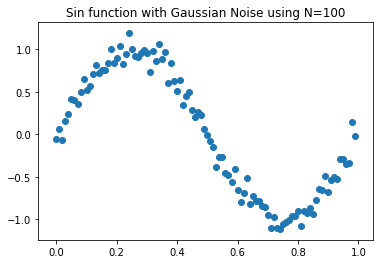


Without using regularized lambda: 




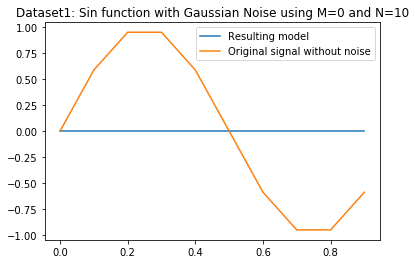

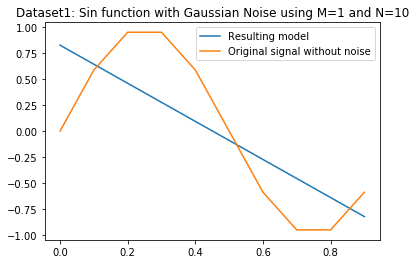

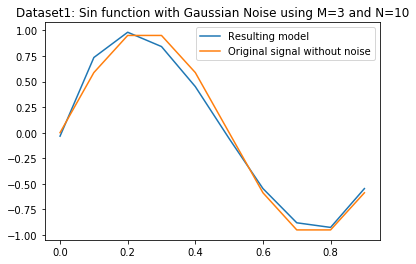

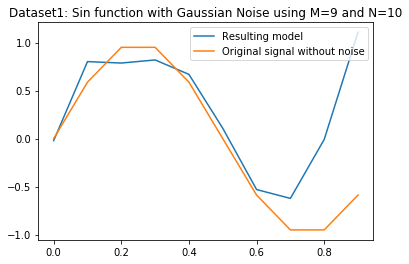

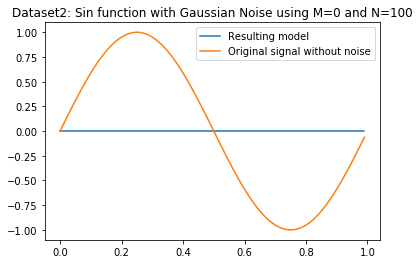

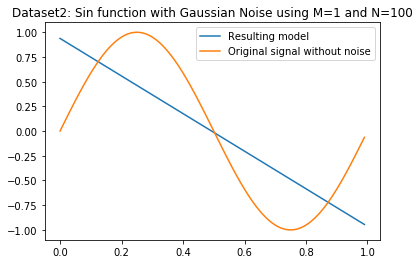

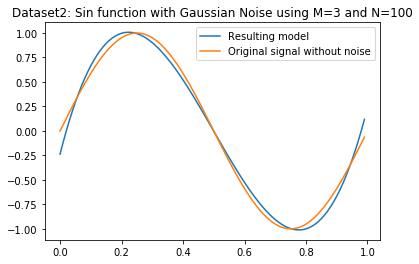

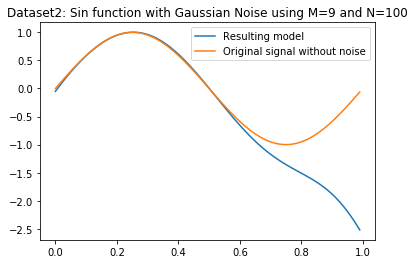


Error for:  Dataset1
Error total para el conjunto de muestras con M: 0, resultado del calculo: 0.369509
Error total para el conjunto de muestras con M: 1, resultado del calculo: 0.266084
Error total para el conjunto de muestras con M: 3, resultado del calculo: 0.009730
Error total para el conjunto de muestras con M: 9, resultado del calculo: 0.247732

Error for:  Dataset2
Error total para el conjunto de muestras con M: 0, resultado del calculo: 0.403765
Error total para el conjunto de muestras con M: 1, resultado del calculo: 0.265720
Error total para el conjunto de muestras con M: 3, resultado del calculo: 0.061217
Error total para el conjunto de muestras con M: 9, resultado del calculo: 0.883335

Using regularized lambda: 




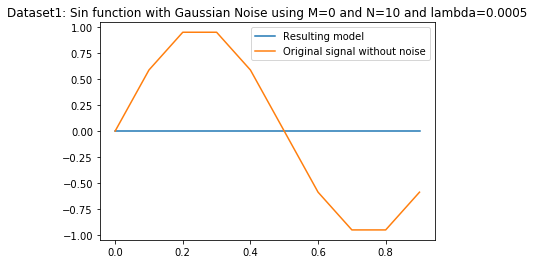

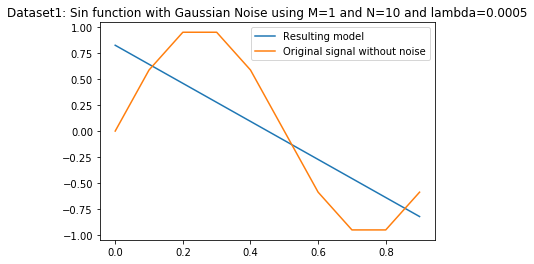

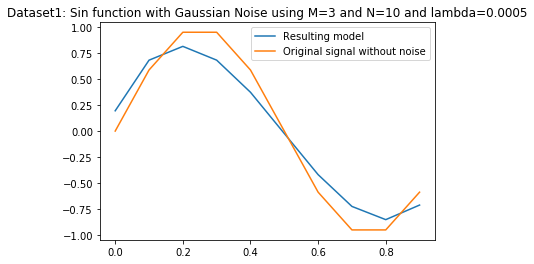

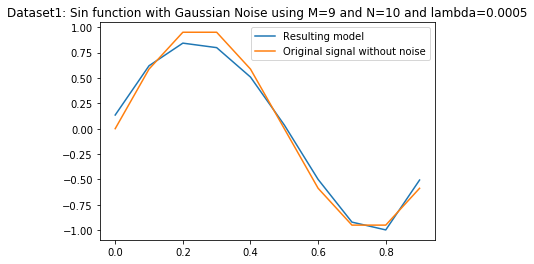

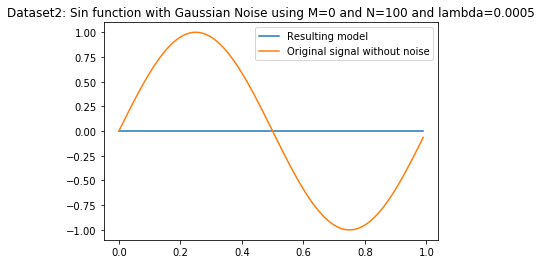

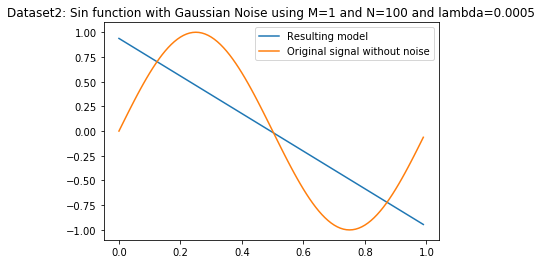

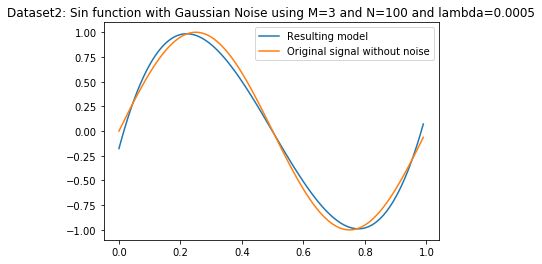

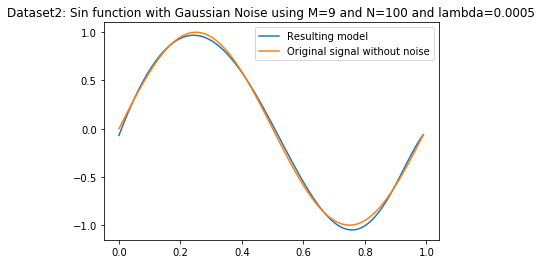

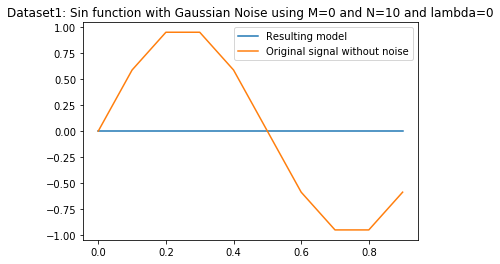

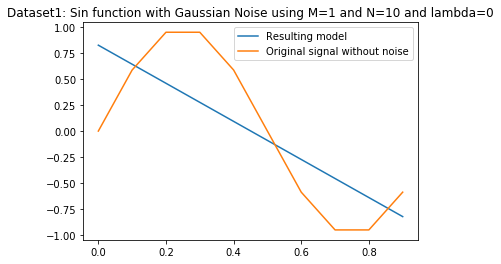

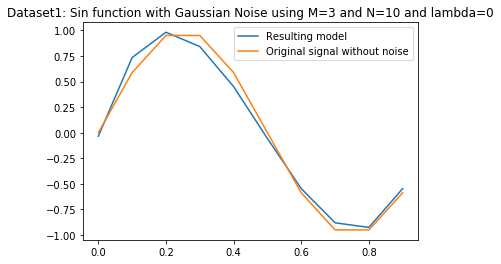

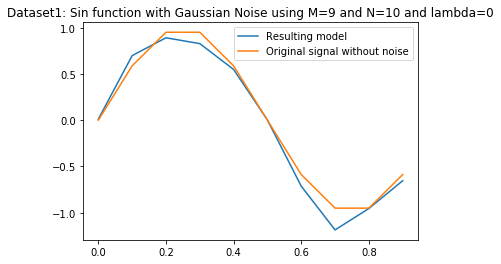

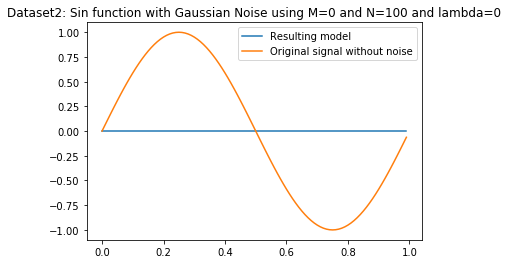

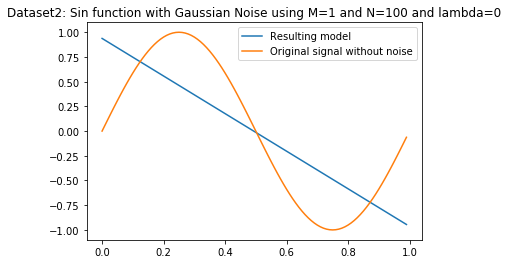

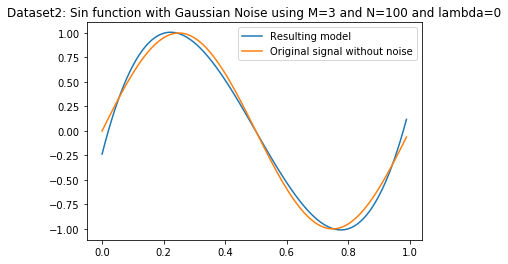

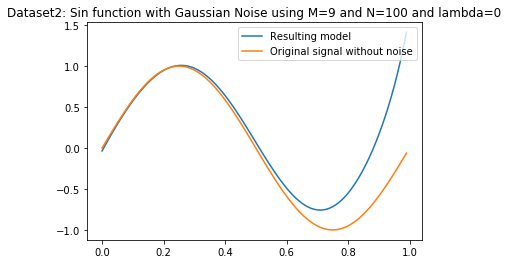

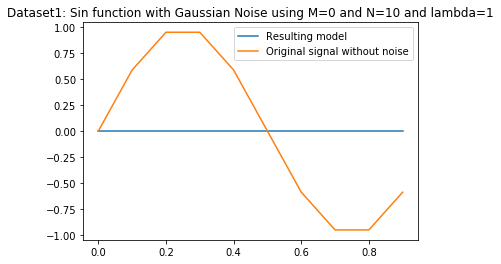

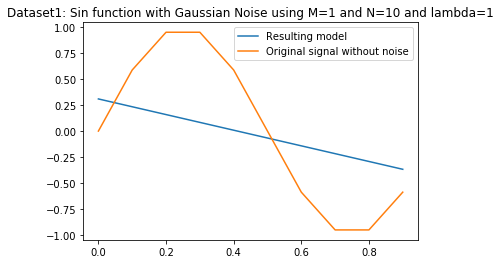

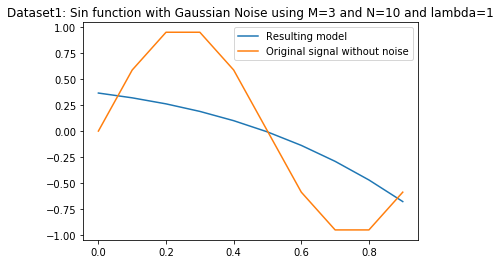

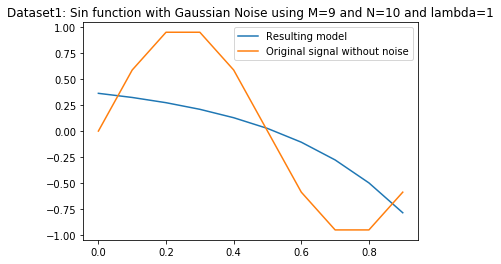

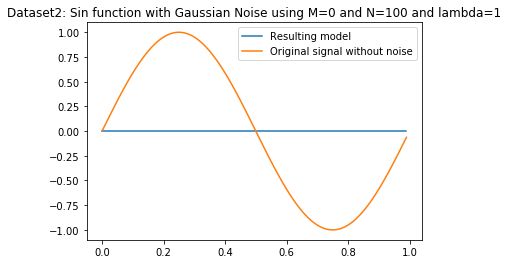

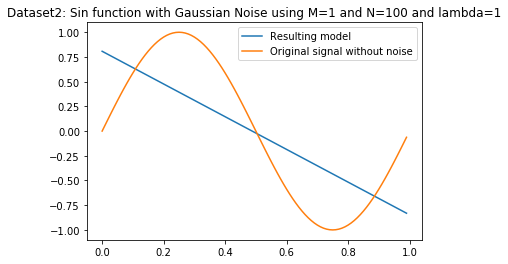

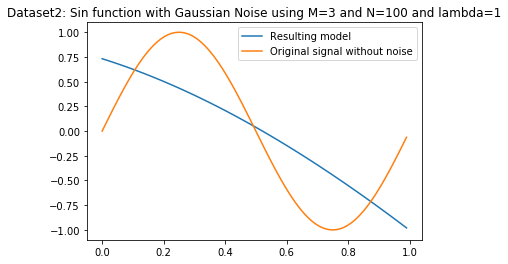

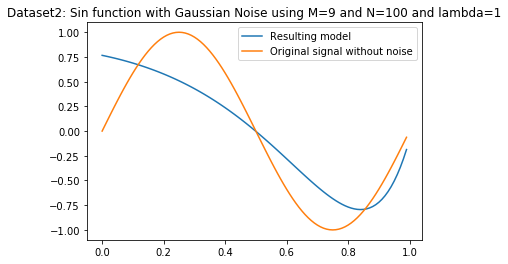


Error for: Dataset1, with lambda: 0.000500
Error total para el conjunto de muestras con M: 0, resultado del calculo: 0.369514
Error total para el conjunto de muestras con M: 1, resultado del calculo: 0.266342
Error total para el conjunto de muestras con M: 3, resultado del calculo: 0.100333
Error total para el conjunto de muestras con M: 9, resultado del calculo: 0.045854

Error for: Dataset1, with lambda: 0.000000
Error total para el conjunto de muestras con M: 0, resultado del calculo: 0.369507
Error total para el conjunto de muestras con M: 1, resultado del calculo: 0.266176
Error total para el conjunto de muestras con M: 3, resultado del calculo: 0.094021
Error total para el conjunto de muestras con M: 9, resultado del calculo: 0.036054

Error for: Dataset1, with lambda: 1.000000
Error total para el conjunto de muestras con M: 0, resultado del calculo: 0.383504
Error total para el conjunto de muestras con M: 1, resultado del calculo: 0.497725
Error total para el conjunto de muestr

In [0]:
def generate_signal(x, stdNoise=0.1):
    """
    Creates the observation array t, from a sinusoidal wave
    @param x, the x values 
    @param stdNoise, standard d
    eviation of noise, hihger, lower signal to noise ratio
    @return (t, yReal), the observed values and the original signal without noise
    """       
    yReal = np.sin(2* np.pi * x);
    # Create noise
    noise = np.random.normal(0, stdNoise, yReal.shape);
    # Additive gaussian noise                        
    t = yReal + noise;
    return (t, yReal);
  
def generate_x_values(n=10):
    maximum_value = 1
    x = np.arange(0, maximum_value, 1/(n/maximum_value));   
    return x
  
def plot_scattered_signal(x, y, title):
    # Scatter of the noisy signal
    plt.scatter(x, y);
    plt.title(title)
    plt.show()

def plot_continuous_signal(x, y1, y_real, title):
    # Scatter of the noisy signal
    plt.plot(x, y1, x, y_real);
    plt.title(title)
    plt.legend(('Resulting model', 'Original signal without noise'),
           loc='upper right')
    plt.show()
    
def get_optimum_w_using_lambda(x, t, M, lambdaF=0.0005):
    # Create base matrix X
    X = np.tile(x,(M,1)).T
    
    # Power matrix elements
    N = len(x)
    for i in range(0, N):
      for j in range(0, M):
        X[i][j] = np.power(X[i][j], j+1)
        
    # Append bias column to X
    biasT = np.ones(len(x)).reshape((len(x),1))
    X = np.concatenate((biasT, X), axis=1)
    
    # Translate as Torch Tensor
    X = torch.from_numpy(X).type(torch.FloatTensor)
    T = torch.from_numpy(t).type(torch.FloatTensor)
    T = T.reshape(-1, T.shape[0])
    
    # print("\nTranspose X mm X and lambda", X.transpose(0, 1).mm(X) + lambdaF*I)
    inversePart = X.transpose(0, 1).mm(X)
    I = torch.eye(list(inversePart.size())[0], list(inversePart.size())[1])
    wOpt = (inversePart + lambdaF*I).inverse().mm(X.transpose(0, 1)).mm(T.transpose(0, 1))
    
    return wOpt
    
    
def get_optimum_w_using_summation(x, t, M):
    def power_matrixA_data(x, degree):
        x_power = np.power(x, degree)
        return np.sum(x_power)
  
    def power_matrixB_data(x, t, degree):
        x_power = np.power(x, degree)
        multiply_factor = np.multiply(x_power, t)
        return np.sum(multiply_factor)
  
    # Create base matrix A
    A = np.ones((M+1, M+1))
    for i in range(0, M+1):
      for j in range(0, M+1):
        A[i][j] = power_matrixA_data(x, i + j)
    
    # Create matrix B
    B = torch.ones(M+1, 1)
    B = B.numpy()
    for i in range(0, M+1):
      B[i] = power_matrixB_data(x, t, i)
      
    # Translate as Torch Tensor
    A = torch.from_numpy(A).type(torch.FloatTensor)
    B = torch.from_numpy(B)
    
    return A.inverse().mm(B)
 
def getY(x, wOpt, M):
    """
    According to the weights w, evaluates the polynomial model
    @param x value to evaluate... i.e. y(xScalar)
    @param w, array of weights for the polynomial model
    @return y
    """
    N = len(x)
    y = np.zeros(N)
    w = wOpt.transpose(0, 1)
    w = w.numpy()[0]

    for i in range(0, N):
      sum_value = 0
      for j in range(0, M+1):
        sum_value += w[j]*(x[i]**j)
      y[i] = sum_value
    
    return y
  
def calculate_error_exercise_2_2(X_train, X_test, T_train, T_test, dataset):
    wOptPerM = []
    # Train model for DataSet1
    for M in [0, 1, 3, 9]:
      # Get optimum value for specific M
      wOpt = get_optimum_w_using_summation(X_train, T_train, M)
      wOptPerM.append((wOpt, M))
      
    # Get all Estimated Y
    estimatedYPerW = []
    for wOpt in wOptPerM:
      estimatedY = getY(X_test, wOpt[0], wOpt[1])
      estimatedYPerW.append(estimatedY)
      
    # Calculate error
    print("\nError for: ", dataset)
    N = len(X_test) + len(X_train)
    for i, estimatedY in enumerate(estimatedYPerW):
      squared_errors = np.sum(np.square(T_test - estimatedY))/2
      erms = np.sqrt((2*squared_errors)/N)
      print("Error total para el conjunto de muestras con M: %d, resultado del calculo: %f" % (wOptPerM[i][1], erms))
      
def calculate_error_exercise_2_3(X_train, X_test, T_train, T_test, dataset):
    for lambdaF in [0.0005, 0, 1]:
      wOptPerM = []
      # Train model for DataSet1
      for M in [0, 1, 3, 9]:
        # Get optimum value for specific M
        wOpt = get_optimum_w_using_lambda(X_train, T_train, M)
        wOptPerM.append((wOpt, M))

      # Get all Estimated Y
      estimatedYPerW = []
      for wOpt in wOptPerM:
        estimatedY = getY(X_test, wOpt[0], wOpt[1])
        estimatedYPerW.append(estimatedY)

      # Calculate error
      print("\nError for: %s, with lambda: %f" % (dataset, lambdaF))
      N = len(X_test) + len(X_train)
      for i, estimatedY in enumerate(estimatedYPerW):
        squared_errors = np.sum(np.square(T_test - estimatedY))/2
        # regularization = np.square(wOptPerM[i][0].numpy())
        regularization = (lambdaF/2)*np.sqrt((np.sum(np.square(wOptPerM[i][0].numpy()))))
        error = squared_errors + regularization
        erms = np.sqrt((2*error)/N)
        print("Error total para el conjunto de muestras con M: %d, resultado del calculo: %f" % (wOptPerM[i][1], erms))

def test_exercise2():
    def test_exercise_2_1():
      # Dataset 1
      x1 = generate_x_values(n=10)
      (t1, y1_real) = generate_signal(x1);
      plot_scattered_signal(x1, t1, "Sin function with Gaussian Noise using N=10")

      # Dataset 2
      print("\n")
      x2 = generate_x_values(n=100)
      (t2, y2_real) = generate_signal(x2);
      plot_scattered_signal(x2, t2, "Sin function with Gaussian Noise using N=100")
      
      return x1, t1, y1_real, x2, t2, y2_real
    
    def test_exercise_2_2(x1, t1, y1_real, x2, t2, y2_real):
      # For Dataset x1 and t1
      for M in [0, 1, 3, 9]:
        # Get optimum value
        wOpt = get_optimum_w_using_summation(x1, t1, M)
        # Plot Fit Y Estimated
        y1 = getY(x1, wOpt, M)
        print("\n")
        plot_continuous_signal(x1, y1, y1_real, "Dataset1: Sin function with Gaussian Noise using M=" + str(M)+ " and N=10")
      
      # For Dataset x2 and t2
      for M in [0, 1, 3, 9]:
        # Get optimum value
        wOpt = get_optimum_w_using_summation(x2, t2, M)
        # Plot Fit Y Estimated
        y2 = getY(x2, wOpt, M)
        print("\n")
        plot_continuous_signal(x2, y2, y2_real, "Dataset2: Sin function with Gaussian Noise using M=" + str(M) + " and N=100")
        
    def test_exercise_2_3(x1, t1, y1_real, x2, t2, y2_real):
      for lambdaF in [0.0005, 0, 1]:
        # For Dataset x1 and t1
        for M in [0, 1, 3, 9]:
          # Get optimum value
          wOpt = get_optimum_w_using_lambda(x1, t1, M, lambdaF)
          # Plot Fit Y Estimated
          y1 = getY(x1, wOpt, M)
          print("\n")
          plot_continuous_signal(x1, y1, y1_real, "Dataset1: Sin function with Gaussian Noise using M=" + str(M)+ " and N=10 and lambda=" + str(lambdaF))

        # For Dataset x2 and t2
        for M in [0, 1, 3, 9]:
          # Get optimum value
          wOpt = get_optimum_w_using_lambda(x2, t2, M, lambdaF)
          # Plot Fit Y Estimated
          y2 = getY(x2, wOpt, M)
          print("\n")
          plot_continuous_signal(x2, y2, y2_real, "Dataset2: Sin function with Gaussian Noise using M=" + str(M) + " and N=100 and lambda=" + str(lambdaF))
    
    # Test exercise 2.1
    x1, t1, y1_real, x2, t2, y2_real = test_exercise_2_1()
    
    # Define the set of training samples as 70% (randomly selected) and test samples as 30%.
    X1_train, X1_test, T1_train, T1_test = tts(x1, t1, test_size = 0.3)
    X2_train, X2_test, T2_train, T2_test = tts(x2, t2, test_size = 0.3)
    
    # Test exercise 2.2
    print("\nExercise 2.3: Without using regularized lambda: ")
    test_exercise_2_2(x1, t1, y1_real, x2, t2, y2_real)
    calculate_error_exercise_2_2(X1_train, X1_test, T1_train, T1_test, "Dataset1")
    calculate_error_exercise_2_2(X2_train, X2_test, T2_train, T2_test, "Dataset2")
    
    # Test exercise 2.3
    print("\nExercise 2.3: Using regularized lambda: ")
    test_exercise_2_3(x1, t1, y1_real, x2, t2, y2_real)
    calculate_error_exercise_2_3(X1_train, X1_test, T1_train, T1_test, "Dataset1")
    calculate_error_exercise_2_3(X2_train, X2_test, T2_train, T2_test, "Dataset2")

    
test_exercise2()